In [1]:
pip install pillow matplotlib scipy pip install opencv-python scikit-learn seaborn opendatasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 14.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 55.3 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 49.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 40.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 68.9 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 78.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 109.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 60.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97

In [1]:
from PIL import Image
import PIL
import scipy
import os
import shutil
import random
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models, layers
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import opendatasets as od
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, Activation, Concatenate, Resizing, Rescaling, Dropout
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

In [2]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory('data_2/train',
                                                             shuffle=True,
                                                             image_size = (224,224),
                                                             batch_size = 16)
dataset_test = tf.keras.preprocessing.image_dataset_from_directory('data_2/test',
                                                             shuffle=True,
                                                             image_size = (224,224),
                                                             batch_size = 16)


Found 720 files belonging to 3 classes.
Found 60 files belonging to 3 classes.


2023-08-09 09:07:48.460873: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 09:07:48.957285: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18300 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:c1:00.0, compute capability: 8.6


In [3]:
dataset_test.class_names

['blight', 'red_scab', 'red_spot']

In [4]:
os.listdir('/workspace/project_e/data_2')

['test', 'train']

In [5]:
class_train = dataset_train.class_names
class_test = dataset_test.class_names
class_val = dataset_train.class_names

In [6]:
train_dt = dataset_train.take(36)
val_dt = dataset_train.skip(36)
test_dt = dataset_test.take(4)

In [7]:
len(train_dt)

36

In [8]:
len(val_dt)

9

In [9]:
len(test_dt)

4

In [10]:
# train_dt = train_dt.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# val_dt = val_dt.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
# test_dt = test_dt.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_scalling = tf.keras.Sequential([
    # layers.experimental.preprocessing.Resizing(224, 224),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [11]:
augmentation_data = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [12]:
def densenet(img_shape, n_classes, f=32):
    def bn_relu_conv(x, f, k=1, s=1, p='same'):
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Conv2D(f, k, strides=s, padding=p)(x)
        return x

    def denseblock(x, r):
        for _ in range(r):
            y = bn_relu_conv(x, 4*f)
            y = bn_relu_conv(y, f, k=3)
            x = tf.keras.layers.Concatenate()([x, y])
        return x

    def trans_layer(x, theta=0.5):
        x = bn_relu_conv(x, f=int(tf.keras.backend.int_shape(x)[-1] * theta))
        x = tf.keras.layers.AveragePooling2D(pool_size=2, strides=2, padding='same')(x)
        return x

    # Input layer
    input_ = tf.keras.layers.Input(img_shape)
    x = resize_scalling(input_)
    x = augmentation_data(x)
    x = tf.keras.layers.Conv2D(32, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    r = [6, 12, 24, 16]
    # r = [6, 12, 24, 16]
    for i in r:
        d = denseblock(x, i)
        x = trans_layer(d)

    x = tf.keras.layers.GlobalAveragePooling2D()(d)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    output_ = tf.keras.layers.Dense(3, activation='softmax')(x)

    model = tf.keras.Model(input_, output_)
    return model

model = densenet((224, 224, 3), 3)

In [13]:
model.build(input_shape=(16,224,224,3))

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 224, 224, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  4736        ['sequential_1[0][0]']       

In [14]:
print(model)

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             run_eagerly=True,
             metrics=['accuracy'])

In [6]:
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(),
#     loss=tf.keras.losses.CategoricalCrossentropy(),
#     run_eagerly=True,
#     metrics=[tf.keras.metrics.CategoricalAccuracy()]
# )
# # model.summary()


In [16]:
anne = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=2, min_lr=0.0003)

In [17]:
checkpoint = ModelCheckpoint('model4.h5', monitor='val_loss', verbose=2, save_best_only=True, mode='min')

In [18]:
history = model.fit(train_dt,
         epochs=100,
         batch_size=16,
         verbose=2,
         callbacks=[anne, checkpoint],
         validation_data=val_dt)

Epoch 1/100


2023-08-09 09:08:41.219410: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-08-09 09:08:42.528454: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.



Epoch 1: val_loss improved from inf to 1.10185, saving model to model4.h5
36/36 - 19s - loss: 0.9538 - accuracy: 0.6337 - val_loss: 1.1019 - val_accuracy: 0.3194 - lr: 1.0000e-04 - 19s/epoch - 522ms/step
Epoch 2/100

Epoch 2: val_loss did not improve from 1.10185
36/36 - 15s - loss: 0.4132 - accuracy: 0.8628 - val_loss: 1.1399 - val_accuracy: 0.3611 - lr: 1.0000e-04 - 15s/epoch - 417ms/step
Epoch 3/100

Epoch 3: val_loss improved from 1.10185 to 1.09048, saving model to model4.h5
36/36 - 16s - loss: 0.1968 - accuracy: 0.9358 - val_loss: 1.0905 - val_accuracy: 0.3889 - lr: 1.0000e-04 - 16s/epoch - 445ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 1.09048
36/36 - 14s - loss: 0.2470 - accuracy: 0.9167 - val_loss: 1.0974 - val_accuracy: 0.3264 - lr: 1.0000e-04 - 14s/epoch - 398ms/step
Epoch 5/100

Epoch 5: val_loss improved from 1.09048 to 0.95694, saving model to model4.h5
36/36 - 16s - loss: 0.1840 - accuracy: 0.9253 - val_loss: 0.9569 - val_accuracy: 0.4444 - lr: 1.0000e-0

In [19]:
score = model.evaluate(test_dt)

print("Test Accuracy:", score[1])
print("Test Loss:", score[0])

4/4 [==============================] - 1s 128ms/step - loss: 1.1829 - accuracy: 0.8000
Test Accuracy: 0.800000011920929
Test Loss: 1.1828933954238892


In [20]:
score

[1.1828933954238892, 0.800000011920929]

In [21]:
history

In [22]:
history.params

{'verbose': 2, 'epochs': 100, 'steps': 36}

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [24]:
len(history.history['accuracy'])

100

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

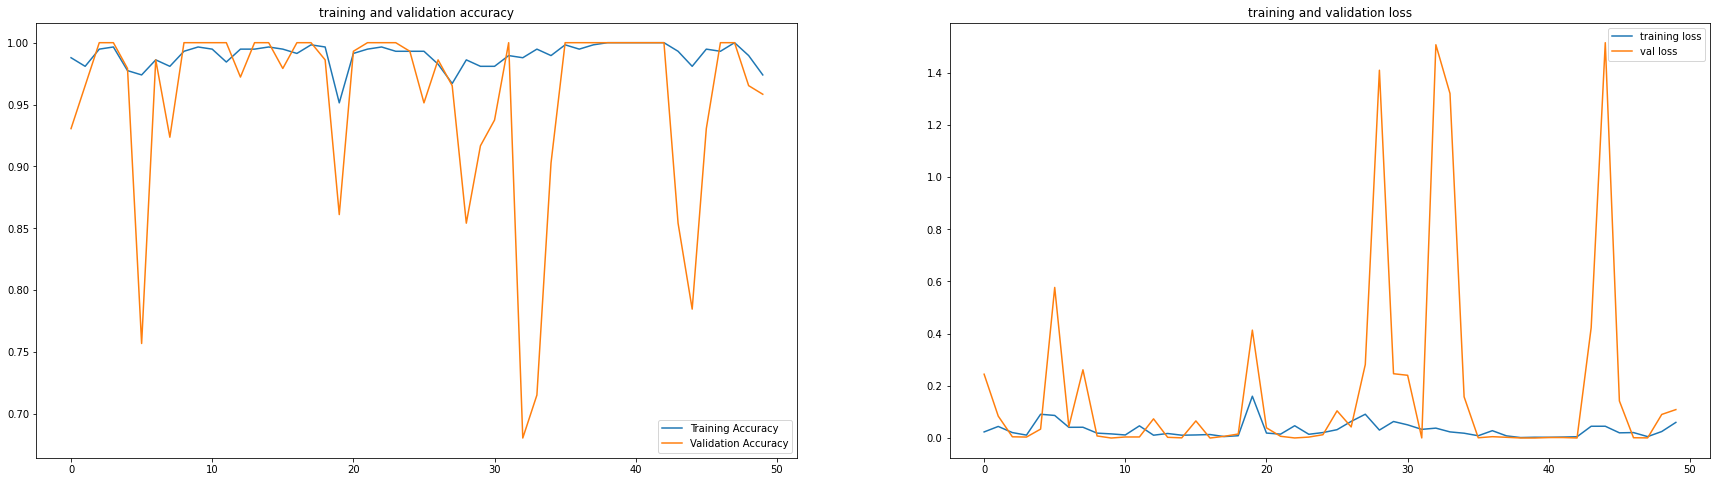

In [26]:
plt.figure(figsize=(30,8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc[50:], label='Training Accuracy')
plt.plot(range(50), val_acc[50:], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('training and validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss[50:], label='training loss')
plt.plot(range(50), val_loss[50:], label='val loss')
plt.legend(loc='upper right')
plt.title('training and validation loss')
plt.show()

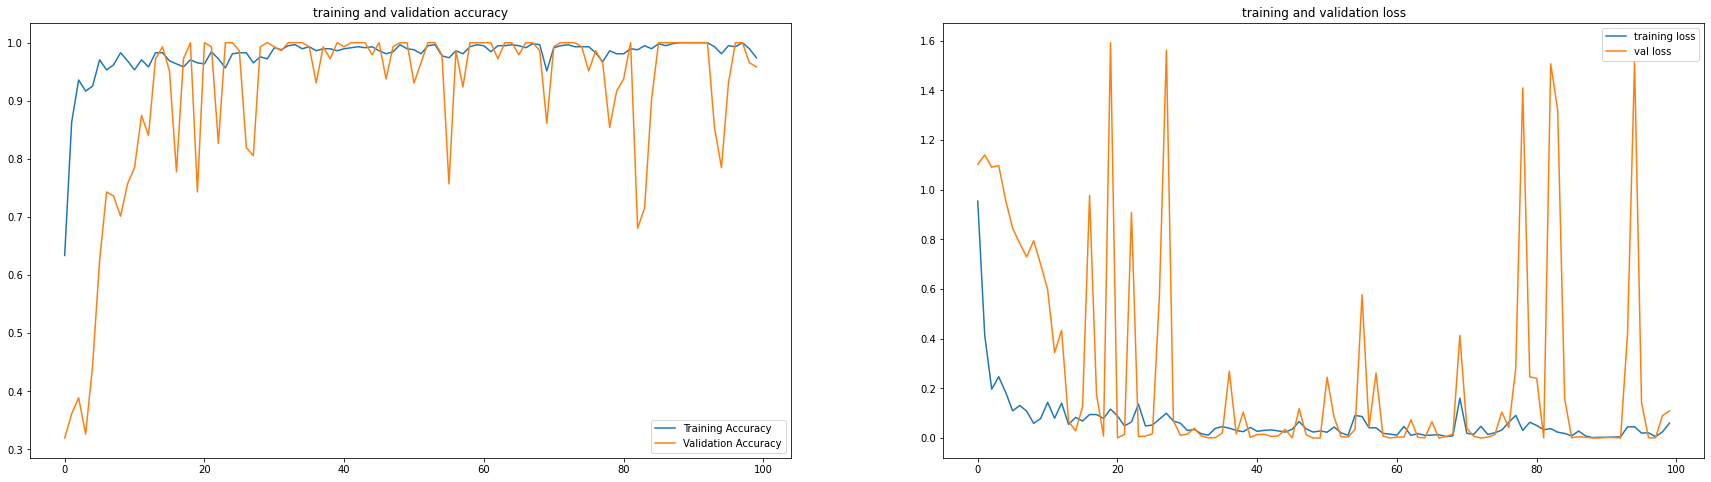

In [27]:
plt.figure(figsize=(30,8))
plt.subplot(1, 2, 1)
plt.plot(range(100), acc, label='Training Accuracy')
plt.plot(range(100), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('training and validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(100), loss, label='training loss')
plt.plot(range(100), val_loss, label='val loss')
plt.legend(loc='upper right')
plt.title('training and validation loss')
plt.show()

actual:  blight
1/1 [==============================] - 0s 125ms/step
predicted:  blight


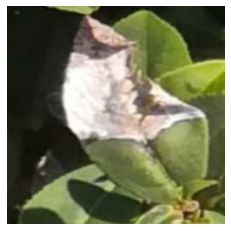

In [29]:
for i, v in test_dt.take(1):
        first_image = i[0].numpy().astype('uint8')
        first_label = v[0].numpy()
        plt.imshow(first_image)
        plt.axis('off')
        print('actual: ',class_test[first_label])
        temp_pred = model.predict(i)

        print('predicted: ',class_test[np.argmax(temp_pred[0])])

In [30]:
def predict_custom(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_test[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 117ms/step


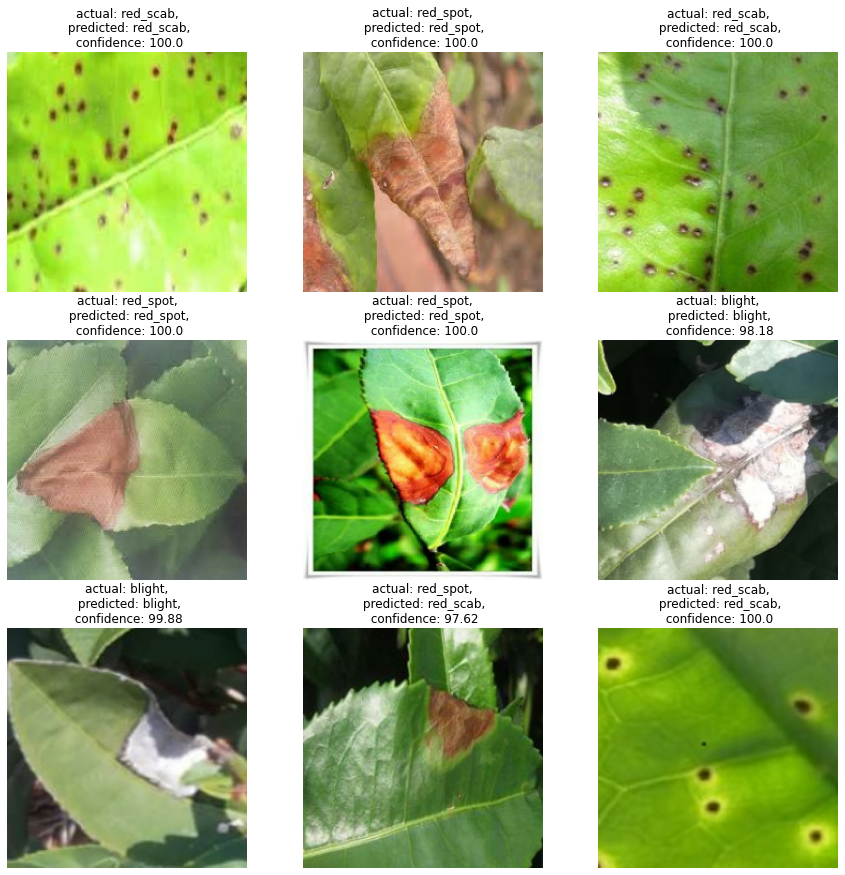

In [31]:
plt.figure(figsize=(15,15))
for images, label in test_dt.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        predicted_class, confidence = predict_custom(model, images[i].numpy())
        actual_class = class_test[label[i]]
        plt.title(f'actual: {actual_class},\n predicted: {predicted_class},\n confidence: {confidence}')
        plt.axis('off')
        plt.imshow(images[i].numpy().astype('uint8'))

In [32]:
ypred = model.predict(test_dt)

4/4 [==============================] - 0s 107ms/step


In [33]:
ypred

array([[2.25559087e-22, 1.32657513e-11, 1.00000000e+00],
       [5.90932103e-38, 9.99999881e-01, 1.08345660e-07],
       [1.12862177e-16, 3.46214976e-03, 9.96537805e-01],
       [1.96253942e-13, 6.57906834e-13, 1.00000000e+00],
       [8.15390231e-05, 1.45582511e-04, 9.99772847e-01],
       [0.00000000e+00, 1.00000000e+00, 3.49894870e-11],
       [5.13723696e-38, 9.98870552e-01, 1.12943654e-03],
       [4.56329311e-28, 1.00000000e+00, 1.65560163e-10],
       [1.00000000e+00, 7.85326838e-12, 3.77919779e-11],
       [2.17603177e-01, 1.12840915e-02, 7.71112680e-01],
       [1.10353857e-37, 9.97229993e-01, 2.76996545e-03],
       [0.00000000e+00, 1.00000000e+00, 3.28513577e-10],
       [0.00000000e+00, 1.00000000e+00, 3.28513577e-10],
       [1.18342235e-30, 9.75337565e-01, 2.46624053e-02],
       [1.95235141e-31, 9.76166427e-01, 2.38335282e-02],
       [9.99955297e-01, 1.99380202e-06, 4.26678453e-05],
       [5.90932103e-38, 9.99999881e-01, 1.08345660e-07],
       [0.00000000e+00, 1.00000

In [34]:
ypred[0]

array([2.2555909e-22, 1.3265751e-11, 1.0000000e+00], dtype=float32)

In [35]:
label_pred = np.argmax(ypred, axis = 1)
label_pred

array([2, 1, 2, 2, 2, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1,
       1, 0, 1, 2, 1, 0, 2, 0, 2, 1, 1, 0, 0, 1, 2, 0, 2, 2, 2, 0, 1, 0,
       1, 2, 2, 0, 2, 2, 2, 1, 1, 1, 2, 2, 0, 2, 2, 1])

In [36]:
label_actual = []
label_pred = []
img_arrays = []

for image_batch, label_batch in test_dt:
    label_batch_np = label_batch.numpy()
    label_actual.append(label_batch_np)
    temp_pred = model.predict(image_batch)
    temp_pred = np.argmax(temp_pred, axis=1)
    label_pred.append(temp_pred)
    img_arrays.extend(image_batch.numpy())

    # After the loop, concatenate the collected label batches
label_actual = np.concatenate(label_actual)
label_pred = np.concatenate(label_pred)
img_arrays = np.array(img_arrays).astype(int)

print(label_actual)
print('\n')
print(label_pred)

1/1 [==============================] - 0s 122ms/step
[1 2 1 2 2 2 0 2 1 0 2 0 0 0 1 1 2 0 1 0 0 0 1 0 2 1 0 0 0 0 2 2 1 2 2 1 2
 0 1 0 0 1 1 1 0 1 1 2 2 0 2 1 1 1 1 0 2 2 2 2]


[1 2 1 2 2 2 2 1 1 0 1 0 0 2 1 1 1 0 1 2 2 2 1 0 1 1 0 0 0 0 2 2 1 2 2 1 1
 2 1 2 0 1 1 1 0 1 1 2 2 0 2 1 1 1 1 0 2 2 2 2]


In [37]:
img_arrays.shape

(60, 224, 224, 3)

In [38]:
from sklearn.metrics import classification_report

In [39]:
print(classification_report(label_actual, label_pred))

              precision    recall  f1-score   support

           0       1.00      0.65      0.79        20
           1       0.80      1.00      0.89        20
           2       0.68      0.75      0.71        20

    accuracy                           0.80        60
   macro avg       0.83      0.80      0.80        60
weighted avg       0.83      0.80      0.80        60



In [40]:
total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i ,v in enumerate(label_actual):
    if v == label_pred[i]:
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)

    total += 1

print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 60 	accurately-predicted-data: 48 	 wrongly-predicted-data:  12
Accuracy: 80.0 %


In [41]:
img_wrong = total - accurate
img_wrong

12

In [42]:
dataset_test.class_names

['blight', 'red_scab', 'red_spot']

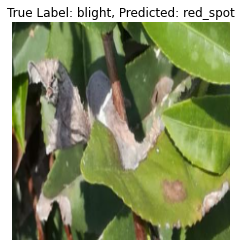

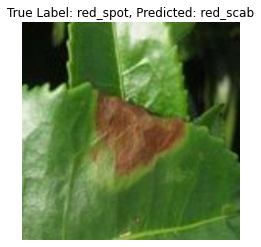

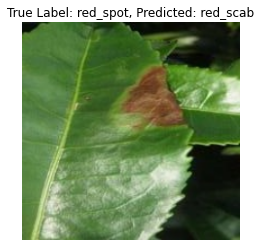

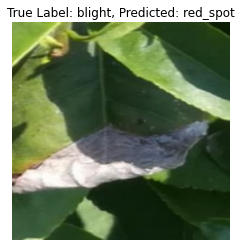

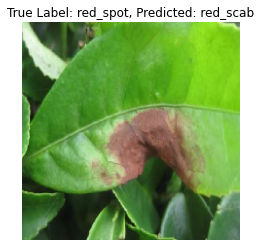

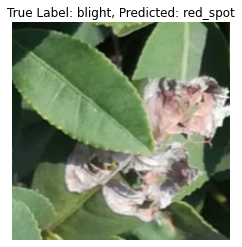

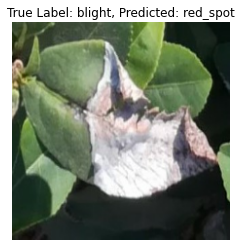

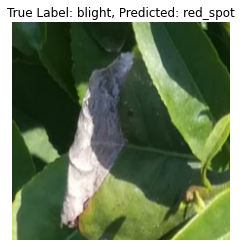

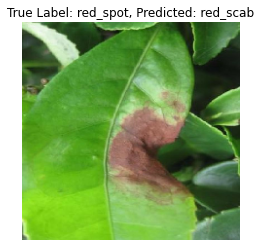

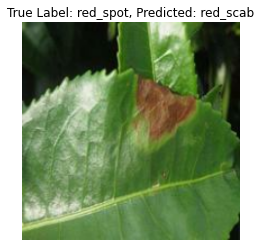

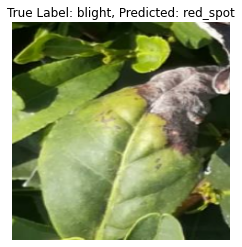

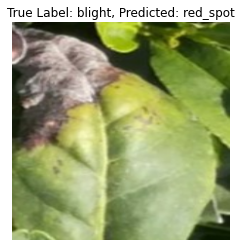

In [43]:
# # Ambil gambar dan label dari data pengujian
images = img_arrays

true_labels = label_actual  # Assuming you have the true labels array 'label_actual'
predicted_labels = label_pred  # Assuming you have the predicted labels array 'label_pred'

# Temukan indeks gambar yang salah diprediksi
misclassified_idx = np.where(true_labels != predicted_labels)[0]

# Tampilkan beberapa gambar yang salah diprediksi
num_images_to_show = img_wrong
for i in range(num_images_to_show):
    idx = misclassified_idx[i]
    img = images[idx]
    true_label = class_test[true_labels[idx]]
    predicted_label = class_test[predicted_labels[idx]]

    plt.imshow(img)
    plt.title(f"True Label: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()


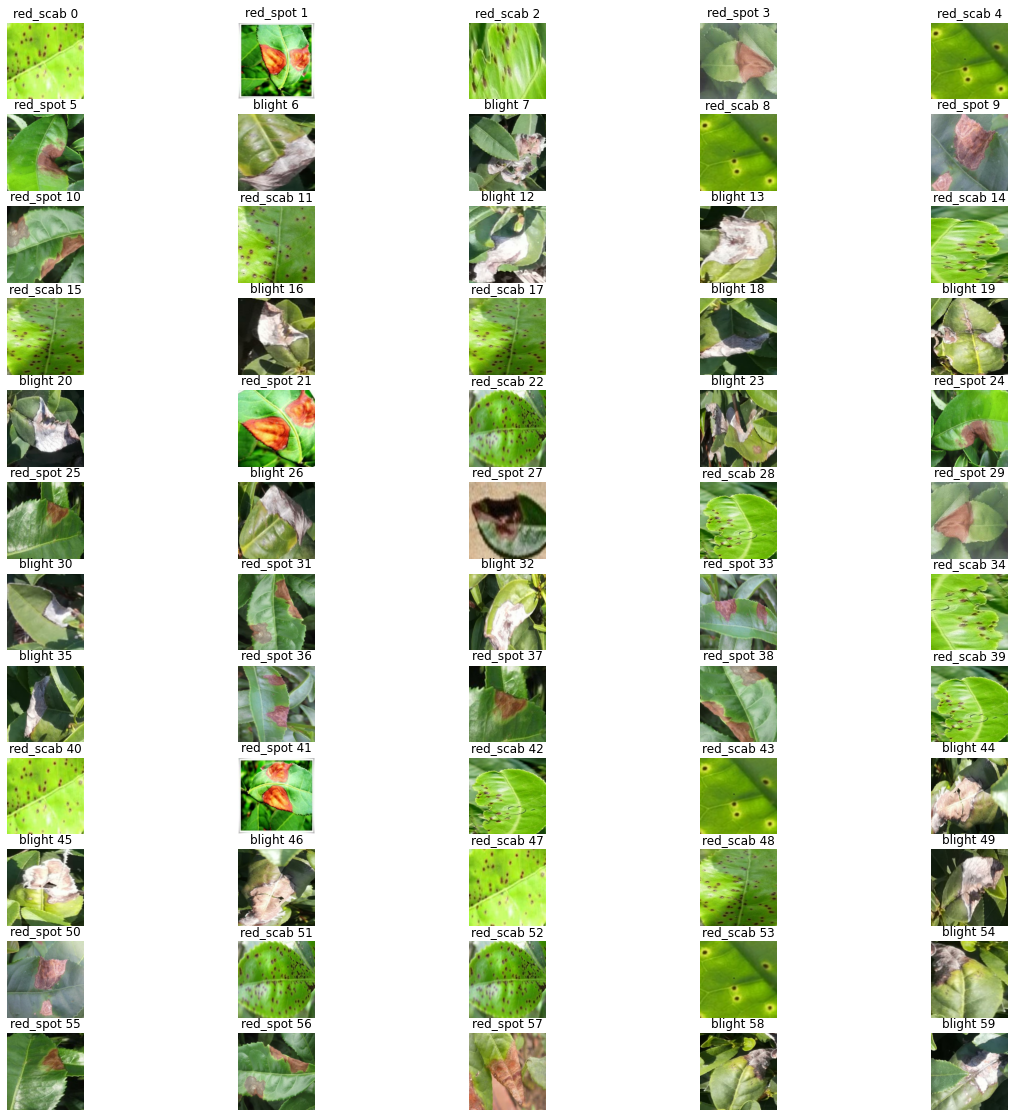

In [166]:
images_list = []
labels_list = []

for image_batch, label_batch in dataset_test:
    images_list.append(image_batch.numpy())
    labels_list.append(label_batch.numpy())

images_np = np.concatenate(images_list, axis=0)
labels_np = np.concatenate(labels_list, axis=0)

# Display all the images using matplotlib.
plt.figure(figsize=(20, 20))
num_images = images_np.shape[0]
num_cols = 5
num_rows = (num_images - 1) // num_cols + 1

for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(images_np[i].astype('uint8'))
    plt.title(f'{class_train[labels_np[i]]} {i}')
    plt.axis('off')

plt.show()

In [232]:
model.save('densenet_fix')

INFO:tensorflow:Assets written to: densenet_fix/assets


INFO:tensorflow:Assets written to: densenet_fix/assets
